In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd

# Load dataset from a CSV file
data_path = '/content/drive/MyDrive/dataset/all-the-news-combined.csv'
data = pd.read_csv(data_path)
data.dropna(subset=['author', 'content'], inplace=True)  # Remove rows with missing 'author' or 'content'

<ipython-input-2-447bde78b5cb>:5: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(data_path)


In [3]:
# Filter data to include only authors with a significant number (400 or more) of articles
author_counts = data['author'].value_counts()
frequent_authors = author_counts[author_counts >= 400].index

# List of grouped authors (not individuals) to be excluded from the analysis
authors_to_exclude = [
    "Associated Press",
    "Breitbart Jerusalem",
    "Breitbart London",
    "Breitbart News",
    "Editorial Board",
    "Fox News",
    "NPR Staff",
    "Post Editorial Board",
    "Post Staff Report",
    "Reuters",
    "The Editors"
]

# Apply filters to the dataset
data = data[data['author'].isin(frequent_authors) & ~data['author'].isin(authors_to_exclude)]

# Display the names of qualified authors
qualified_authors = data['author'].unique()
print("Qualified Authors:")
for author in qualified_authors:
    print(author)

Qualified Authors:
Camila Domonoske
Merrit Kennedy
Bill Chappell
Ian Hanchett
Katherine Rodriguez
Jerome Hudson
Charlie Spiering
AWR Hawkins
Warner Todd Huston
Jeff Poor
Trent Baker
Daniel Nussbaum
John Hayward
Pam Key
Joel B. Pollak
Charlie Nash
Alex Swoyer


In [4]:
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

# Function to preprocess text by removing digits, punctuation, and stop words, and applying lemmatization
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    text = text.lower()  # Convert text to lowercase
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    words = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    return ' '.join(lemmatizer.lemmatize(word) for word in words if word not in stop_words)

# Apply preprocessing to each content entry in the dataset
data['processed_content'] = data['content'].apply(preprocess_text)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Prepare for TF-IDF vectorization
all_words = set()
data['processed_content'].str.split().apply(all_words.update)
max_features = len(all_words)  # Set the maximum number of features as the total number of unique words

# Vectorize the processed text using TF-IDF method
tfidf_vectorizer = TfidfVectorizer(max_features=max_features, min_df=3, max_df=0.9, ngram_range=(1, 2))
X = tfidf_vectorizer.fit_transform(data['processed_content'])
y = data['author']

In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Encode author names into categorical labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [7]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Initialize and train an SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

# Initialize and train a Logistic Regression model
log_reg_model = LogisticRegression(max_iter=1000)
log_reg_model.fit(X_train, y_train)
y_pred_log_reg = log_reg_model.predict(X_test)

# Print classification reports for SVM and Logistic Regression
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm, target_names=encoder.classes_))

print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log_reg, target_names=encoder.classes_))

SVM Classification Report:
                     precision    recall  f1-score   support

        AWR Hawkins       1.00      0.99      0.99       170
        Alex Swoyer       0.85      0.86      0.85       112
      Bill Chappell       0.77      0.52      0.62        90
   Camila Domonoske       0.63      0.73      0.67       121
       Charlie Nash       0.97      0.94      0.96        90
   Charlie Spiering       0.84      0.95      0.89       188
    Daniel Nussbaum       0.97      0.95      0.96       147
       Ian Hanchett       1.00      1.00      1.00       119
          Jeff Poor       1.00      0.99      1.00       105
      Jerome Hudson       0.96      0.97      0.96       179
     Joel B. Pollak       0.97      0.87      0.92       117
       John Hayward       0.90      0.88      0.89       162
Katherine Rodriguez       0.73      0.86      0.79        73
     Merrit Kennedy       0.68      0.70      0.69        92
            Pam Key       1.00      0.97      0.98       

SVM Model Evaluation
Accuracy: 0.9068067610781179
Precision: 0.8979417680785388
Recall: 0.8919921269310614
F1 Score: 0.8926374262128024


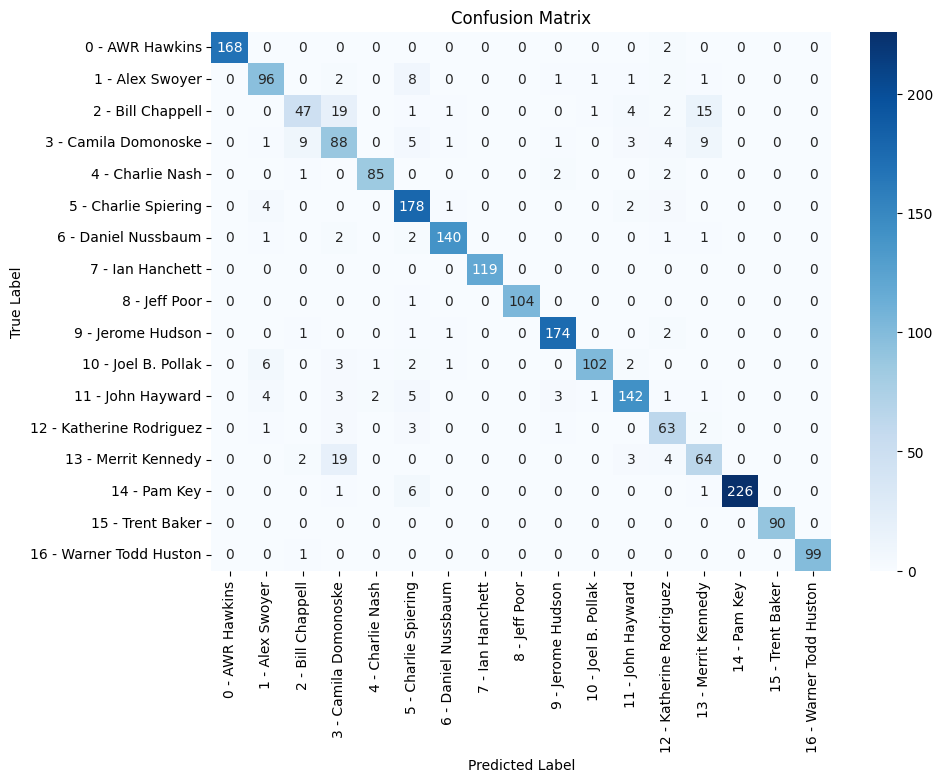

Detailed Confusion Matrix Breakdown:
Author 0 - TP: 168, FP: 0, FN: 2, TN: 2019
Author 1 - TP: 96, FP: 17, FN: 16, TN: 2060
Author 2 - TP: 47, FP: 14, FN: 43, TN: 2085
Author 3 - TP: 88, FP: 52, FN: 33, TN: 2016
Author 4 - TP: 85, FP: 3, FN: 5, TN: 2096
Author 5 - TP: 178, FP: 34, FN: 10, TN: 1967
Author 6 - TP: 140, FP: 5, FN: 7, TN: 2037
Author 7 - TP: 119, FP: 0, FN: 0, TN: 2070
Author 8 - TP: 104, FP: 0, FN: 1, TN: 2084
Author 9 - TP: 174, FP: 8, FN: 5, TN: 2002
Author 10 - TP: 102, FP: 3, FN: 15, TN: 2069
Author 11 - TP: 142, FP: 15, FN: 20, TN: 2012
Author 12 - TP: 63, FP: 23, FN: 10, TN: 2093
Author 13 - TP: 64, FP: 30, FN: 28, TN: 2067
Author 14 - TP: 226, FP: 0, FN: 8, TN: 1955
Author 15 - TP: 90, FP: 0, FN: 0, TN: 2099
Author 16 - TP: 99, FP: 0, FN: 1, TN: 2089
Logistic Regression Model Evaluation
Accuracy: 0.8899040657834628
Precision: 0.8851168331651307
Recall: 0.8668714084298104
F1 Score: 0.8696341129450338


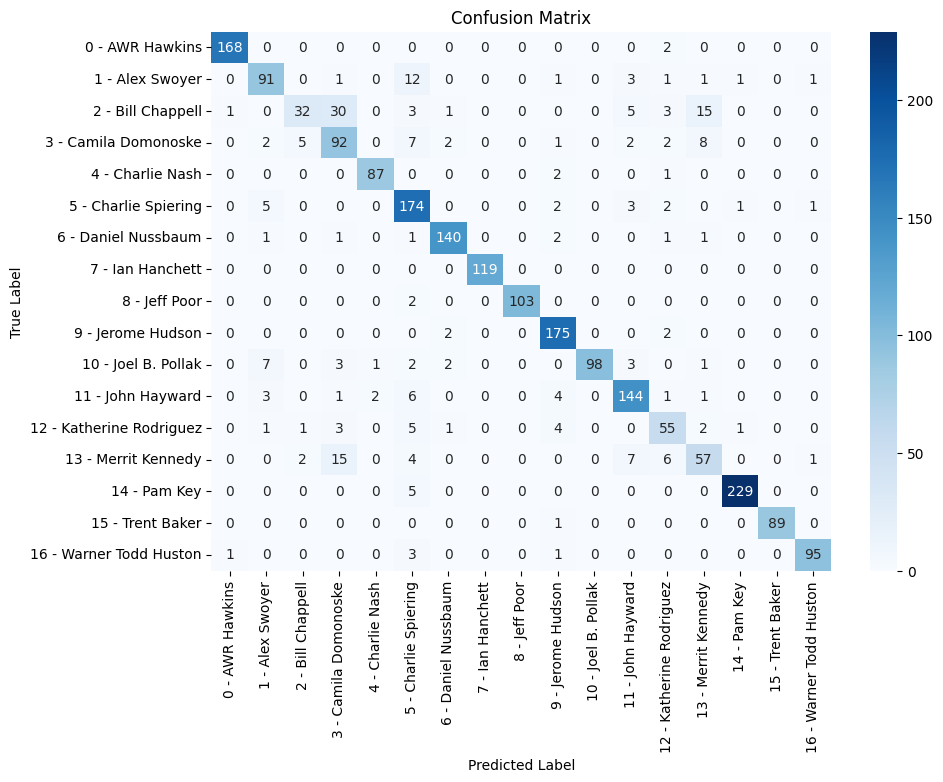

Detailed Confusion Matrix Breakdown:
Author 0 - TP: 168, FP: 2, FN: 2, TN: 2017
Author 1 - TP: 91, FP: 19, FN: 21, TN: 2058
Author 2 - TP: 32, FP: 8, FN: 58, TN: 2091
Author 3 - TP: 92, FP: 54, FN: 29, TN: 2014
Author 4 - TP: 87, FP: 3, FN: 3, TN: 2096
Author 5 - TP: 174, FP: 50, FN: 14, TN: 1951
Author 6 - TP: 140, FP: 8, FN: 7, TN: 2034
Author 7 - TP: 119, FP: 0, FN: 0, TN: 2070
Author 8 - TP: 103, FP: 0, FN: 2, TN: 2084
Author 9 - TP: 175, FP: 18, FN: 4, TN: 1992
Author 10 - TP: 98, FP: 0, FN: 19, TN: 2072
Author 11 - TP: 144, FP: 23, FN: 18, TN: 2004
Author 12 - TP: 55, FP: 21, FN: 18, TN: 2095
Author 13 - TP: 57, FP: 29, FN: 35, TN: 2068
Author 14 - TP: 229, FP: 3, FN: 5, TN: 1952
Author 15 - TP: 89, FP: 0, FN: 1, TN: 2099
Author 16 - TP: 95, FP: 3, FN: 5, TN: 2086


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    labels = [f'{i} - {cls}' for i, cls in enumerate(classes)]
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    return cm

# Function to evaluate the model and print performance metrics
def evaluate_model(name, y_true, y_pred, classes):
    print(f"{name} Model Evaluation")
    accuracy = accuracy_score(y_true, y_pred)
    print("Accuracy:", accuracy)
    precision = precision_score(y_true, y_pred, average='macro')
    print("Precision:", precision)
    recall = recall_score(y_true, y_pred, average='macro')
    print("Recall:", recall)
    f1 = f1_score(y_true, y_pred, average='macro')
    print("F1 Score:", f1)
    cm = plot_confusion_matrix(y_true, y_pred, classes)
    print("Detailed Confusion Matrix Breakdown:")
    for i in range(len(classes)):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        tn = cm.sum() - (tp + fp + fn)
        print(f"Author {i} - TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}")

# Evaluate and print the performance of the SVM and Logistic Regression models
evaluate_model("SVM", y_test, y_pred_svm, encoder.classes_)
evaluate_model("Logistic Regression", y_test, y_pred_log_reg, encoder.classes_)

In [9]:
pip install joblib

In [10]:
from joblib import dump

# Save the SVM model
dump(svm_model, '/content/svm_model.joblib')

# Save the Logistic Regression model
dump(log_reg_model, '/content/log_reg_model.joblib')

# Save the TF-IDF Vectorizer
dump(tfidf_vectorizer, '/content/tfidf_vectorizer.joblib')

# Save the LabelEncoder
dump(encoder, '/content/label_encoder.joblib')

['/content/label_encoder.joblib']

In [11]:
import zipfile

# Create a zip file containing all necessary files
with zipfile.ZipFile('/content/model_files.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write('/content/svm_model.joblib', arcname='svm_model.joblib')
    zipf.write('/content/log_reg_model.joblib', arcname='log_reg_model.joblib')
    zipf.write('/content/tfidf_vectorizer.joblib', arcname='tfidf_vectorizer.joblib')
    zipf.write('/content/label_encoder.joblib', arcname='label_encoder.joblib')